In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Punto 1:

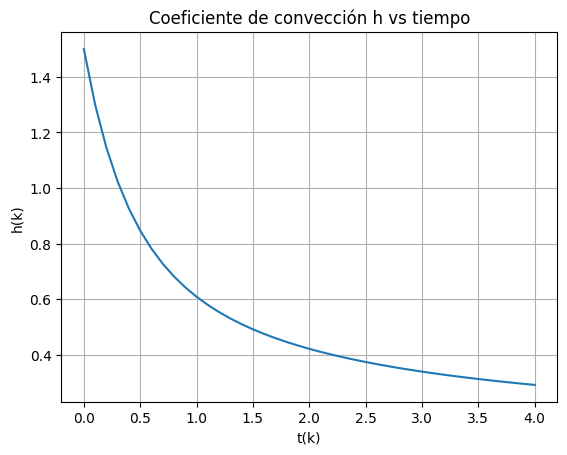

In [94]:
# Parámetros
dy = 1
dt = 0.1
alpha = 1
kf = alpha
N = 40
K = 40

# Mallado
y = np.arange(0, N+1) * dy
t = np.arange(0, K+1) * dt

# Matriz de temperaturas
T = np.zeros((K+1, N+1))

# Condición inicial
T[0,0] = 1
T[0,1:] = 0

# Iteración temporal usando ecuación (3)
for k in range(1, K+1):
    for n in range(1, N):   # n=1..N-1
        T[k,n] = T[k-1,n] + alpha * dt / dy**2 * (T[k-1,n-1] + T[k-1,n+1] - 2*T[k-1,n])

        
    T[k,0] = 1   # placa caliente
    T[k,N] = 0   # extremo lejano frío

# Calcular derivada ∂T/∂y|0
dTdy = np.zeros(K+1)
for k in range(K+1):
    dTdy[k] = (-3/2*T[k,0] + 2*T[k,1] - 1/2*T[k,2]) / dy

Tp = 1
Tinf = 0
h = (-kf * dTdy) / (Tp - Tinf)

# Graficar h vs k
plt.plot(t, h)
plt.xlabel("t(k)")
plt.ylabel("h(k)")
plt.title("Coeficiente de convección h vs tiempo")
plt.grid(True)
plt.show()


Punto 2 y 3:

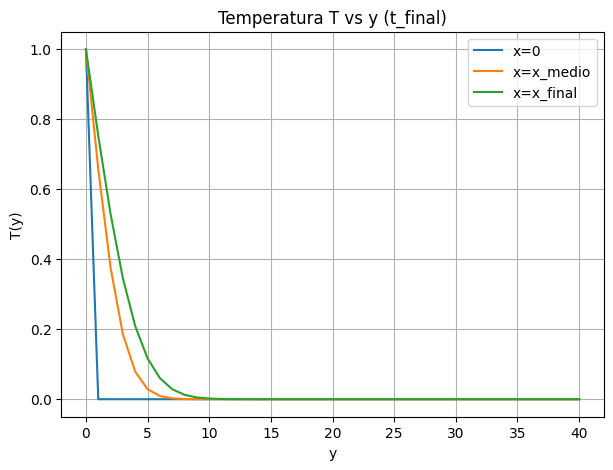

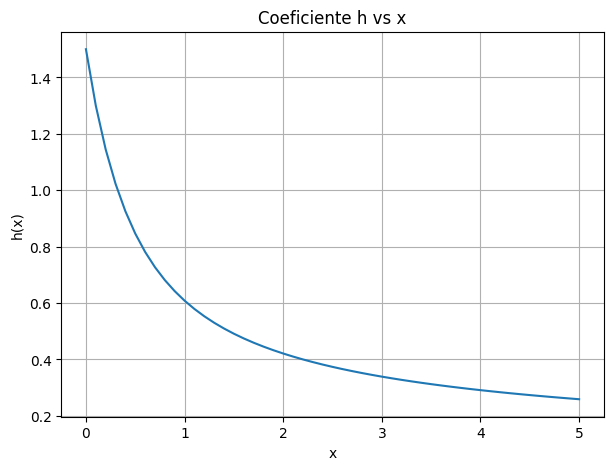

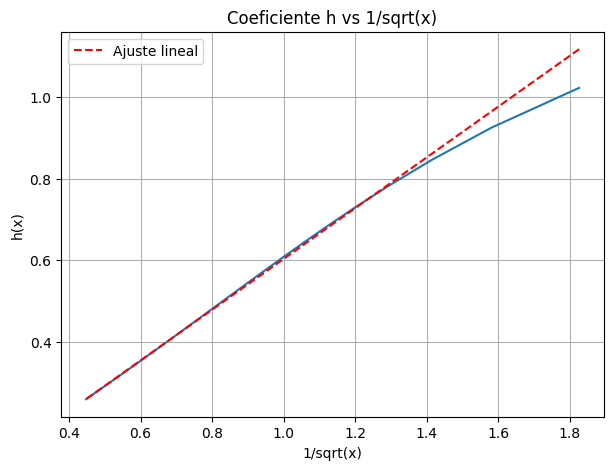

In [102]:
# ---------------------------------------------------
# Parámetros físicos y numéricos
# ---------------------------------------------------
dy = 1
dt = 0.1
alpha = 1.0
Uinf = 1.0
dx = Uinf * dt

Tp = 1.0
Tinf = 0.0
kf = alpha

# Mallado

N = 40   # puntos en y
K = 50  # pasos de tiempo
I = K   # puntos en x

# T[k,i,n] = tiempo k, posición x->i, y->n
T = np.zeros((K+1, I+1, N+1))

# ---------------------------------------------------
# CONDICIONES INICIALES 
# ---------------------------------------------------
# Fluido frío en todo el dominio
T[0,:,:] = Tinf

# Fluido en contacto con la pared caliente en y=0
T[0,:,0] = Tp

# ---------------------------------------------------
# BUCLE PRINCIPAL
# ---------------------------------------------------
for k in range(1, K+1):
    # ======== 1. DIFUSIÓN (conducción en y) ========
    T_cond = np.copy(T[k-1])  # copia de la capa anterior
    for i in range(I+1):
        for n in range(1, N):
            T_cond[i,n] = ( T[k-1,i,n] 
                            + alpha * (dt / dy**2) *
                              ( T[k-1,i,n-1] + T[k-1,i,n+1] - 2*T[k-1,i,n] )
                          )

        # Condiciones de borde en y
        T_cond[i,0] = Tp     # pared caliente
        T_cond[i,N] = Tinf   # temperatura fria del fluido lejos de la pared

    # ======== 2. TRANSPORTE: T(x+dx) = T_cond(x) ========
    # fluido avanza en +x
    for i in range(1, I+1):
        T[k,i,:] = T_cond[i-1,:]

    # condición de entrada en y=0 (fluido frío + pared caliente)
    T[k,:,0] = Tp
    T[k,0,1:] = Tinf

# ---------------------------------------------------
# Calcular dT/dy y coeficiente h
# ---------------------------------------------------
dTdy = np.zeros((K+1, I+1))

for k in range(K+1):
    for i in range(I+1):
        dTdy[k,i] = (-1.5*T[k,i,0] + 2*T[k,i,1] - 0.5*T[k,i,2]) / dy

h = -kf * dTdy / (Tp - Tinf)

# Posiciones
x = np.arange(0, I+1) * dx
inv_sqrt_x = np.zeros_like(x)
inv_sqrt_x[1:] = 1/np.sqrt(x[1:])

y = np.arange(0, N+1) * dy
# ---------------------------------------------------
# Gráfica final
# ---------------------------------------------------
plt.figure(figsize=(7,5))
plt.plot(y, T[K,0,:], label='x=0')
plt.plot(y, T[K,25,:], label='x=x_medio')
plt.plot(y, T[K,I,:], label='x=x_final')
plt.legend()
plt.xlabel('y')
plt.ylabel('T(y)')
plt.grid(True)
plt.title('Temperatura T vs y (t_final)')
plt.show()


plt.figure(figsize=(7,5))
plt.plot(x, h[K,:])
plt.xlabel('x')
plt.ylabel('h(x)')
plt.grid(True)
plt.title('Coeficiente h vs x')
plt.show()

model1 = LinearRegression()
model1.fit(inv_sqrt_x[5:].reshape(-1,1), h[K,5:])  # Ignorar el primer punto donde x=0
h_pred = model1.predict(inv_sqrt_x[3:].reshape(-1,1))


plt.figure(figsize=(7,5))
plt.plot(inv_sqrt_x[3:], h[K,3:]) #Se ignoran pequeños valores de x
plt.plot(inv_sqrt_x[3:], h_pred, '--', color='red', label='Ajuste lineal')
plt.legend()
plt.xlabel('1/sqrt(x)')
plt.ylabel('h(x)')
plt.grid(True)
plt.title('Coeficiente h vs 1/sqrt(x)')
plt.show()


Punto 4:

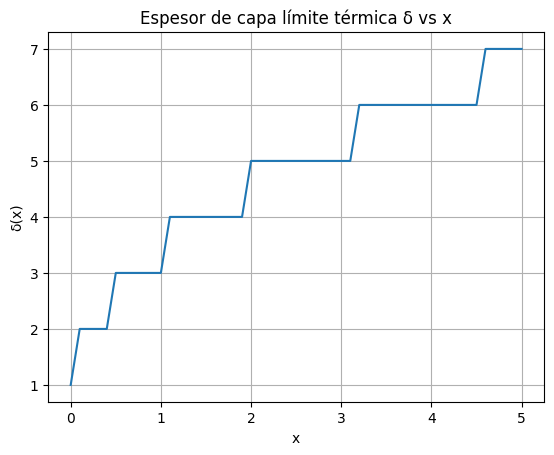

Ecuación ajustada: δ(x) = 2.7080 * sqrt(x) + 0.7261


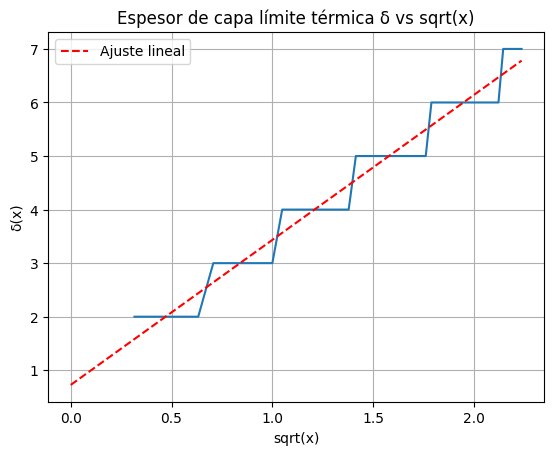

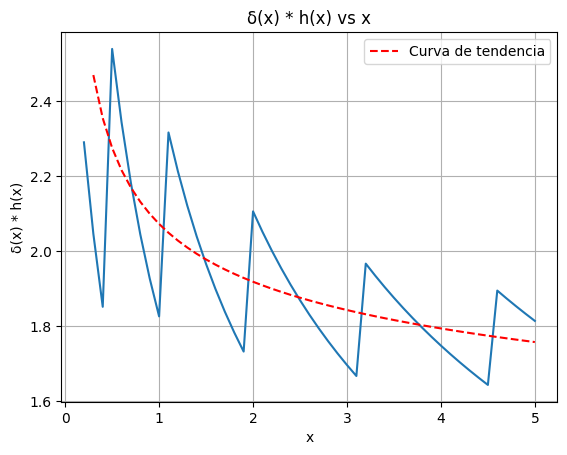

In [109]:
# ----------------------------------------
# Calcular delta(x, t_final)
# ----------------------------------------
delta = np.zeros(I+1)
T_threshold = 0.05 * (Tp - Tinf)

k_final = K  # t_final = 50 dt

for i in range(I+1):
    # Buscar el primer 'y' donde T cae por debajo del umbral
    cont = True
    for n in range(N+1):
        if T[k_final, i, n] <= T_threshold and cont:
            delta[i] = n * dy
            cont = False
        elif T[k_final, i, n] > T_threshold and cont:
            delta[i] = (N) * dy  # si no se encuentra, asignar el valor máximo

sqrt_x = np.sqrt(x)

plt.figure()
plt.plot(x, delta)
plt.xlabel('x')
plt.ylabel('δ(x)')
plt.title('Espesor de capa límite térmica δ vs x')
plt.grid(True)
plt.show()

# Ajuste lineal simple
model = LinearRegression()
model.fit(sqrt_x[1:].reshape(-1,1), delta[1:])  # Ignorar el primer punto donde x=0

delta_pred = model.predict(sqrt_x[:].reshape(-1,1))
m = model.coef_[0]      # pendiente
b = model.intercept_    # intercepto

print(f"Ecuación ajustada: δ(x) = {m:.4f} * sqrt(x) + {b:.4f}")

plt.figure()
plt.plot(sqrt_x[1:], delta[1:])  
plt.plot(sqrt_x[:], delta_pred, '--r', label="Ajuste lineal")
plt.xlabel('sqrt(x)')
plt.ylabel('δ(x)')
plt.legend()
plt.title('Espesor de capa límite térmica δ vs sqrt(x)')
plt.grid(True)
plt.show()

delta_h = delta[2:] * h[K,2:]
delta_h_pred = delta_pred[3:] * h_pred



plt.figure()
plt.plot(x[2:], delta_h)  # Ignorar pequeños valores de x
plt.plot(x[3:], delta_h_pred, "--r", label = "Curva de tendencia" )  # Ignorar pequeños valores de x
plt.xlabel('x')
plt.ylabel('δ(x) * h(x)')
plt.title('δ(x) * h(x) vs x')
plt.legend()
plt.grid(True)
plt.show()



Punto 5:

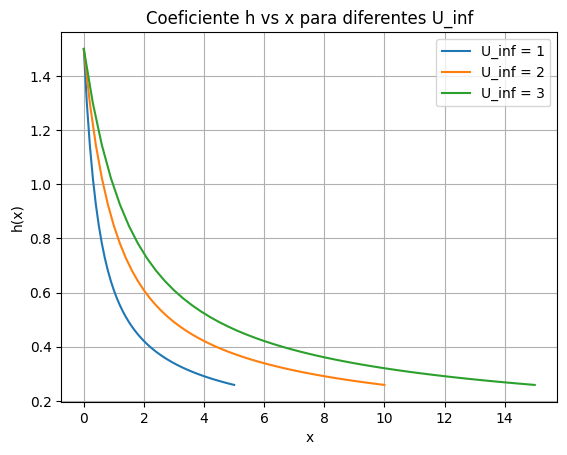

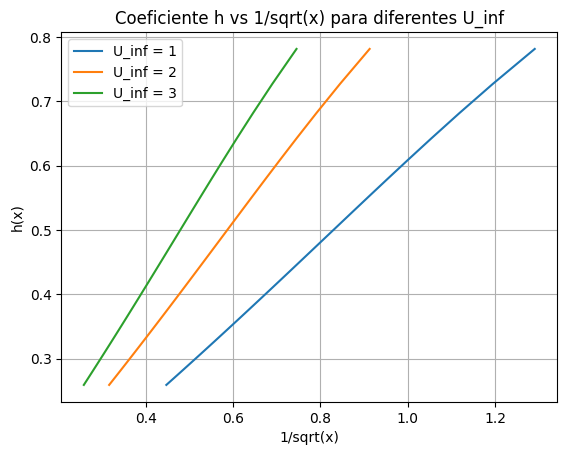

In [97]:
x2 = np.arange(0, I+1) * (2*dx)
x3 = np.arange(0, I+1) * (3*dx)

sqrt_x2 = np.sqrt(x2)
sqrt_x3 = np.sqrt(x3)

inv_sqrt_x2 = np.zeros_like(x2)
inv_sqrt_x2[1:] = 1/np.sqrt(x2[1:])
inv_sqrt_x3 = np.zeros_like(x3)
inv_sqrt_x3[1:] = 1/np.sqrt(x3[1:])

plt.figure()
plt.plot(x, h[K,:], label='U_inf = 1')
plt.plot(x2, h[K,:], label='U_inf = 2')
plt.plot(x3, h[K,:], label='U_inf = 3')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.legend()
plt.grid(True)
plt.title('Coeficiente h vs x para diferentes U_inf')
plt.show()

plt.figure()
plt.plot(inv_sqrt_x[6:], h[K,6:], label='U_inf = 1')
plt.plot(inv_sqrt_x2[6:], h[K,6:], label='U_inf = 2')
plt.plot(inv_sqrt_x3[6:], h[K,6:], label='U_inf = 3')
plt.xlabel('1/sqrt(x)')
plt.ylabel('h(x)')
plt.legend()
plt.grid(True)
plt.title('Coeficiente h vs 1/sqrt(x) para diferentes U_inf')
plt.show()

Punto 6:

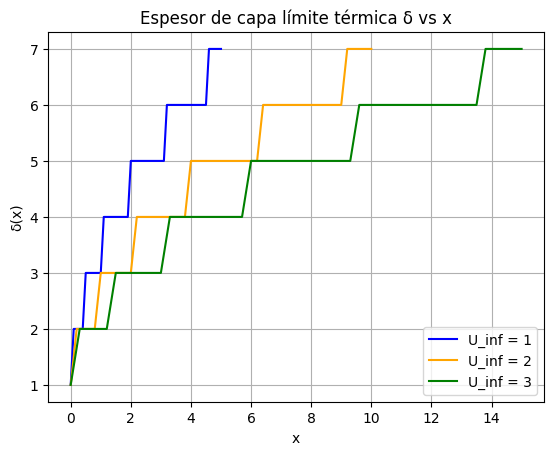

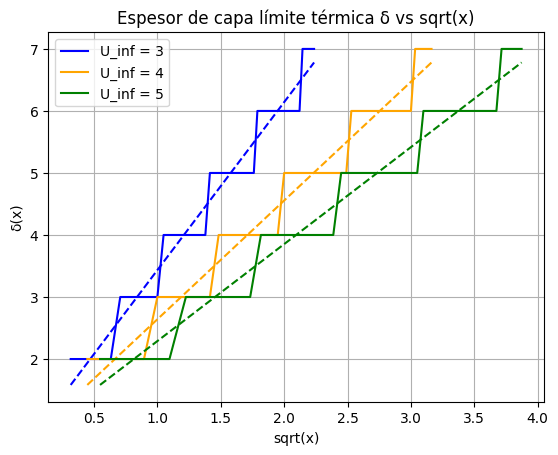

In [98]:
plt.figure()
plt.plot(x, delta, label='U_inf = 1', color = 'blue')
plt.plot(x2, delta, label='U_inf = 2', color = 'orange')
plt.plot(x3, delta, label='U_inf = 3', color = 'green')
plt.xlabel('x')
plt.ylabel('δ(x)')
plt.legend()
plt.title('Espesor de capa límite térmica δ vs x')
plt.grid(True)
plt.show()

# Ajuste lineal simple
model = LinearRegression()


plt.figure()
list = [sqrt_x, sqrt_x2, sqrt_x3]
colors = ['blue', 'orange', 'green']
for r in range(len(list)):
    plt.plot(list[r][1:], delta[1:], label=f'U_inf = {(list[r][1]/(dt*Uinf))-2:.0f}', color = colors[r])  # Evitar x=0
    model.fit(list[r][1:].reshape(-1,1), delta[1:])  # Ignorar el primer punto donde x=0
    delta_pred = model.predict(list[r][1:].reshape(-1,1))
    plt.plot(list[r][1:], delta_pred, '--', color=colors[r])
plt.xlabel('sqrt(x)')
plt.ylabel('δ(x)')
plt.legend()
plt.title('Espesor de capa límite térmica δ vs sqrt(x)')
plt.grid(True)

Punto 7:

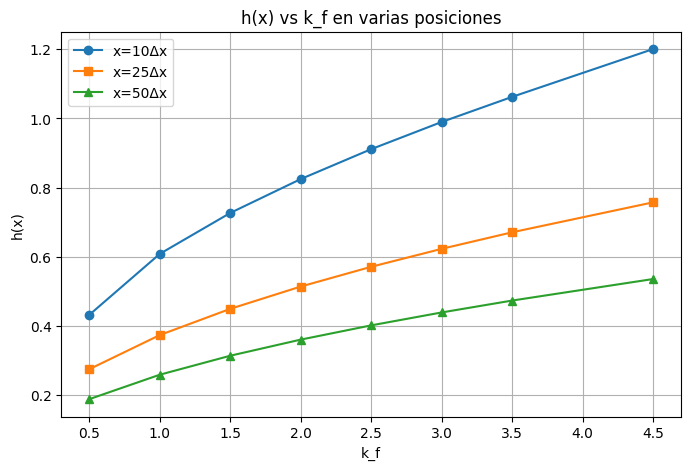

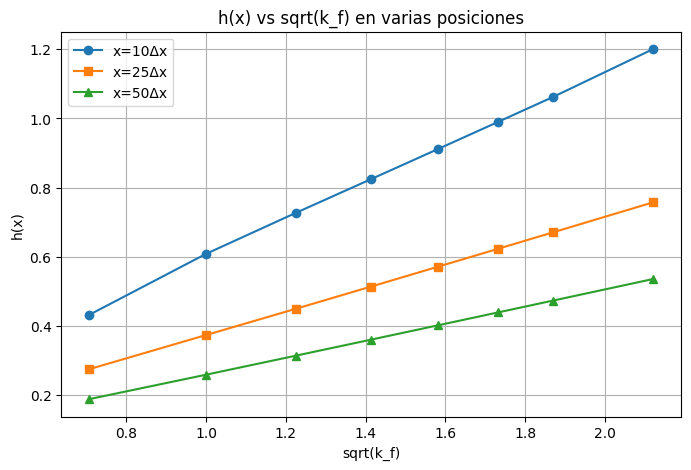

In [99]:
# ---------------------------------------------------
# Función que corre la simulación para un valor dado de kf
# ---------------------------------------------------
def run_simulation(kf, K=50, dy=1.0, Uinf=1.0, Tp=1.0, Tinf=0.0):
    
    alpha = kf          # como rho*cp = 1
    dt_base = 0.1       #dt original
    dx = Uinf * dt_base    
    

    # Mallado
    N = 40
    I = K

    # T[k, i, n] = t=k, x=i, y=n
    T = np.zeros((K+1, I+1, N+1))

    # Condiciones iniciales
    T[0, :, :] = Tinf
    T[0, :, 0] = Tp
    T[0, 0, :] = Tinf
    T[0, 0, 0] = Tp  # pared en x=0

    # ---------------------------------------------------
    # Bucle principal
    # ---------------------------------------------------
    for k in range(1, K+1):
        # ----- 1. Conducción en y -----
        T_cond = T[k-1].copy()
        for i in range(I+1):
            for n in range(1, N):
                T_cond[i, n] = ( T[k-1, i, n] 
                                + alpha * dt/dy**2 
                                * (T[k-1, i, n-1] + T[k-1, i, n+1] - 2*T[k-1, i, n]) )
            T_cond[i, 0] = Tp
            T_cond[i, N] = Tinf

        # ----- 2. Transporte en x -----
        for i in range(1, I+1):
            T[k, i, :] = T_cond[i-1, :]

        # Condiciones de pared
        T[k, :, 0] = Tp
        T[k, 0, 1:] = Tinf

    # ---------------------------------------------------
    # Calcular h almacenando dT/dy en y=0
    # ---------------------------------------------------
    dTdy = np.zeros(I+1)
    for i in range(I+1):
        dTdy[i] = (-1.5*T[K, i, 0] + 2*T[K, i, 1] - 0.5*T[K, i, 2]) / dy  #Esta vez se calcula dTdy solo para t_final.

    h = -kf * dTdy / (Tp - Tinf)
    
    x = np.arange(I+1) * dx
    
    return x, h

# =======================================================
# BARRIDO EN k_f
# =======================================================
k_values = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.5])

h_at_x10 = []
h_at_x25 = []
h_at_x50 = []

for kf in k_values:
    x, h = run_simulation(kf)
    
    # índices correspondientes
    h_at_x10.append(h[10])
    h_at_x25.append(h[25])
    h_at_x50.append(h[50])

sqrt_kf = np.sqrt(k_values)

# =======================================================
# GRAFIQUE h vs kf en tres posiciones
# =======================================================
plt.figure(figsize=(8,5))
plt.plot(k_values, h_at_x10, 'o-', label='x=10Δx')
plt.plot(k_values, h_at_x25, 's-', label='x=25Δx')
plt.plot(k_values, h_at_x50, '^-', label='x=50Δx')
plt.xlabel("k_f")
plt.ylabel("h(x)")
plt.title("h(x) vs k_f en varias posiciones")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(sqrt_kf, h_at_x10, 'o-', label='x=10Δx')
plt.plot(sqrt_kf, h_at_x25, 's-', label='x=25Δx')
plt.plot(sqrt_kf, h_at_x50, '^-', label='x=50Δx')
plt.xlabel("sqrt(k_f)")
plt.ylabel("h(x)")
plt.title("h(x) vs sqrt(k_f) en varias posiciones")
plt.grid(True)
plt.legend()
plt.show()




Punto 8: